# 이미지 이상탐지모델(GAN)

- 딥러닝 기술이 유용하게 사용될 수 있는 대표적인 사례로 바로 이상감지(Anomaly Detection)를 꼽을 수 있습니다. 혹시라도 위험한 물품이 포함되어 있지 않을까 24시간 사람이 뚫어져라 모니터를 쳐다보고 있어야만 하는 고된 일을 인공지능이 대신 정확하게 수행해 줄 수 있다면 좋겠죠? 이런 과제는 실제로 공항, 항만, 주요 군사시설 등에서 매우 관심을 가지고 진행하고 있답니다. 그런데 이런 이상감지 모델로 GAN 기술이 유용하게 활용되고 있다고 합니다.

- 왜 그럴까요? 그냥 쉽게 생각할 수 있는 지도학습(supervised learning)으로는 어려울까요? 네 그렇습니다. 이상감지 태스크의 경우, 정상(Normal) 상황에 대한 데이터는 아주 풍부하게 얻을 수 있지만, 이상(Anomaly) 상황에 대한 데이터는 매우 부족할 뿐 아니라 사실상 모든 케이스의 이상 상황을 정의할 수조차 없기 때문입니다. 이 때 GAN이 사용된다면 이상(Anomaly) 데이터가 충분하지 않은 경우에도 꽤 쓸만한 이상감지 성능을 발휘하는 모델을 만들 수 있다고 합니다.

## 학습목표
- 이상(Anomaly) 데이터가 부족한 상황에서 GAN을 이용해 이미지 이상감지 모델을 구축하는 논리를 파악한다.
- Skip-GANomaly 모델 및 Loss 함수를 구현해 본다.
- 간단한 데이터셋을 이용해 Skip-GANomaly 의 이상감지 효과를 파악해 본다.

## 학습 목차
- Anomaly Detection with GAN
- GANomaly
- Skip-GANomaly
- 데이터셋 구성
- 모델과 Loss함수 구성
- 모델 학습과 평가

## 평가 루브릭

- 아래의 기준을 바탕으로 프로젝트를 평가합니다.

###  평가문항	상세기준
1. Anomaly Detection 태스크 특성에 맞도록 데이터셋 가공이 진행되었다.: 개구리 클래스가 배제되어 테스트셋에만 반영되는 로직이 구현되었다.
2. Skip-GANomaly 모델이 정상적으로 구현되었다.: 모델 학습 및 테스트가 원활하게 진행되었다.
3. 이상감지 수행 결과가 체계적으로 시각화되었다. : 정상-이상 데이터의 anomaly score 분포 시각화, 테스트셋 이상감지 정확도(%), 적절한 threshold에 따른 이상 감지율 계산, 이상감지 성공실패사례 제시가 진행되었다.

# ★ 프로젝트: 개구리 이상감지 경고 시스템 (CIFAR-10) ★ 

- 이번 프로젝트는 CIFAR-10 데이터셋에 대해 진행해 보겠습니다. 
- CIFAR-10의 10가지 클래스 중 개구리 라벨을 이상 데이터로 처리하는 모델입니다. 
- 혹시 개구리가 출현할 경우 이를 감지하여 이상감지 경고를 발생시키는 개구리 감지 모델이라고 할 수 있겠습니다.

# 데이터셋 구성(Fashion-MNIST)

- 지금부터는 Skip-GANomaly 모델을 실제로 구현하는 과정을 진행하려고 합니다. 
- 이런 이상감지 모델을 학습할 때 쉽게 사용하는 데이터 구성은 MNIST 같이 잘 알려진 데이터셋에서 특정 클래스를 이상 데이터로 활용하는 방식입니다. 
- 예를 들어 0으로 라벨링된 모든 이미지를 훈련 데이터에서 제거하고 1~9로만 학습을 시킨 후 테스트 데이터를 0을 포함한(이상 데이터를 포함한) 형태로 구성하여 이상감지 성능을 평가하는 방식입니다.

- CIFAR-10에서 6번 라벨이 개구리(Frog)입니다. 개구리를 제거하고 나머지 클래스로 구성된 CIFAR-10 데이터를 정상 데이터로 삼아볼 생각입니다.

- 말하자면, 우리의 모델은 개구리는 보도 듣도 못하였으며, 개구리가 나타나면 매우 특이한 상황이라고 가정하는 것입니다.

In [13]:
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display
import warnings
warnings.filterwarnings("ignore")

# 이상감지용 데이터셋 구축

## 개구리 데이터를 학습데이터셋에서 제외하여 테스트 데이터셋에 포함

- 위에서 언급한 대로 학습/테스트 데이터셋을 구축해 보겠습니다.

- CIFAR-10 이미지를 사용하도록 하겠습니다. 

    - 3채널 color 데이터셋입니다. Convolution 연산의 reshape 과정이 필요없습니다. 
    - 데이터 이미지 사이즈는 32 X 32이므로 바로 Unet 구조 활용이 가능합니다.

In [14]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

from PIL import Image

print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


- 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
- 로드한 CIFAR-10 학습 데이터를 시각화를 통해 확인해 봅시다.
- 개구리가 몇번째 클래스인지 확인합니다. 

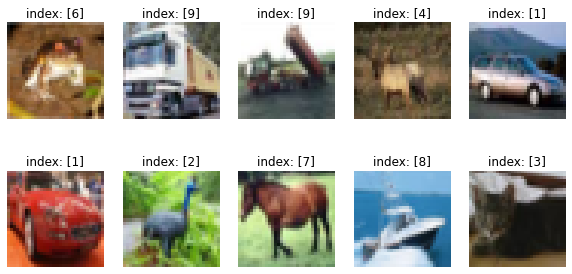

In [15]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i])
    plt.title(f'index: {train_labels[i]}')
    plt.axis('off')
plt.show()

In [16]:
# 이미지를 [-1, 1]로 정규화합니다

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

# float32 데이터 타입 변환
train_data = train_data.reshape(train_data.shape[0], 32, 32, 3).astype('float32')
test_data = test_data.reshape(test_data.shape[0], 32, 32, 3).astype('float32')

- 위에서 확인한대로 개구리는 6번 라벨입니다. 
- 이상 데이터로 선정된 6번 라벨(Frog) 데이터를 제외하도록 하겠습니다.

In [17]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:   # Frog: 6
            new_t_labels.append([0])  # Frog를 이상치로 처리
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [18]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [19]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [20]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [21]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [22]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [23]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 1)
(15000, 1)


- 어떻습니까? 50000건의 훈련데이터 중 5000건이 제외되어 10000건의 테스트 데이터에 추가되었습니다. 계산이 맞아떨어지나요?

- 데이터셋이 정확하게 구성되었는지 좀더 검증해 보겠습니다.

In [24]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


- 이제 데이터셋을 구성하고 label을 검증해 보겠습니다.

- 훈련 데이터셋에는 라벨이 1인 데이터만 존재하고, 테스트 데이터에는 0과 1이 섞여 있어야 합니다.

In [25]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [26]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [27]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


# Skip-GANomaly 모델의 구현


![title](Skip-GANomaly1.png)


![title](Skip-GANomaly2.png)

# 모델과 Loss함수 구성

## Generator
- 이제 본격적으로 모델을 구성해 보겠습니다. Generator는 그동안 자주 다루었을 UNet 구조를 따릅니다.

In [30]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [31]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [32]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same', use_bias=False, # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

# Discriminator
- Discriminator도 Generator처럼 Conv_block을 활용하며, 최종적으로 sigmoid를 거쳐 0~1 사이의 숫자를 리턴합니다.

In [33]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                          use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

# 전체 모델 구성
- Generator와 Discriminator을 합쳐 전체 모델을 구성해 봅시다.

In [34]:
generator = Generator(num_output_channel=3)  # Generator가 32X32X3 짜리 이미지를 생성해야 합니다. 
discriminator = Discriminator()

# Loss 함수
- GAN 모델의 핵심은 Loss 함수의 구성방법에 달려 있다고 해도 과언이 아닙니다. Skip-GANomaly는 이전 모델들과 달리 일반적인 GAN의 학습 절차와 같은 형태의 Loss 구성이 진행됩니다.

In [35]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [36]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

- 아래 Generator Loss에는 이전 스텝에서 설명했던 Skip-GANomaly의 주요 loss 함수들이 포함되어 있음을 주목해 주세요.

In [37]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

In [38]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

# 모델의 학습과 검증

# 모델 학습과 평가
## Model Train
- 이제 본격적으로 모델을 학습해 보겠습니다. 총 25Epoch 대략 1시간 정도 소요될 수 있습니다.

In [39]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [40]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/GANomaly/ganomaly_skip_no_norm/ckpt1')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- 총 25Epoch 를 수행하는데 1시간 이상 소요될 수 있습니다.

In [41]:
max_epochs = 25
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

Steps : 100, 	 Total Gen Loss : 15.815467834472656, 	 Total Dis Loss : 0.7031910419464111
Steps : 200, 	 Total Gen Loss : 14.48637580871582, 	 Total Dis Loss : 0.6611581444740295
Steps : 300, 	 Total Gen Loss : 13.749415397644043, 	 Total Dis Loss : 0.43466949462890625
Steps : 400, 	 Total Gen Loss : 16.813297271728516, 	 Total Dis Loss : 0.18940326571464539
Steps : 500, 	 Total Gen Loss : 16.877653121948242, 	 Total Dis Loss : 0.22833698987960815
Steps : 600, 	 Total Gen Loss : 16.804868698120117, 	 Total Dis Loss : 0.18955302238464355
Steps : 700, 	 Total Gen Loss : 19.250600814819336, 	 Total Dis Loss : 0.09161704778671265
Steps : 800, 	 Total Gen Loss : 19.456636428833008, 	 Total Dis Loss : 0.05770651996135712
Steps : 900, 	 Total Gen Loss : 15.807043075561523, 	 Total Dis Loss : 0.335244357585907
Steps : 1000, 	 Total Gen Loss : 16.363182067871094, 	 Total Dis Loss : 0.18576966226100922
Steps : 1100, 	 Total Gen Loss : 21.272216796875, 	 Total Dis Loss : 0.03137286752462387
Steps

Steps : 9000, 	 Total Gen Loss : 21.733951568603516, 	 Total Dis Loss : 0.0017634622054174542
Steps : 9100, 	 Total Gen Loss : 24.32892608642578, 	 Total Dis Loss : 0.0007471144199371338
Steps : 9200, 	 Total Gen Loss : 23.572294235229492, 	 Total Dis Loss : 0.0011965675512328744
Steps : 9300, 	 Total Gen Loss : 22.01616668701172, 	 Total Dis Loss : 0.00048491364577785134
Steps : 9400, 	 Total Gen Loss : 20.655738830566406, 	 Total Dis Loss : 0.009413281455636024
Steps : 9500, 	 Total Gen Loss : 21.480621337890625, 	 Total Dis Loss : 0.0035270885564386845
Steps : 9600, 	 Total Gen Loss : 22.567258834838867, 	 Total Dis Loss : 0.005727842450141907
Steps : 9700, 	 Total Gen Loss : 23.2332820892334, 	 Total Dis Loss : 0.0016675324877724051
Steps : 9800, 	 Total Gen Loss : 22.51403045654297, 	 Total Dis Loss : 0.018338318914175034
Steps : 9900, 	 Total Gen Loss : 21.059600830078125, 	 Total Dis Loss : 0.0032747890800237656
Steps : 10000, 	 Total Gen Loss : 21.5417537689209, 	 Total Dis Los

Steps : 17700, 	 Total Gen Loss : 22.308940887451172, 	 Total Dis Loss : 0.0036539831198751926
Steps : 17800, 	 Total Gen Loss : 24.658531188964844, 	 Total Dis Loss : 0.0007067082915455103
Steps : 17900, 	 Total Gen Loss : 22.478927612304688, 	 Total Dis Loss : 0.002006187802180648
Steps : 18000, 	 Total Gen Loss : 20.76793670654297, 	 Total Dis Loss : 0.0031881683971732855
Steps : 18100, 	 Total Gen Loss : 29.89868927001953, 	 Total Dis Loss : 0.0002159212453989312
Steps : 18200, 	 Total Gen Loss : 22.89667320251465, 	 Total Dis Loss : 0.0034000417217612267
Steps : 18300, 	 Total Gen Loss : 23.682844161987305, 	 Total Dis Loss : 0.0006416812539100647
Steps : 18400, 	 Total Gen Loss : 24.191680908203125, 	 Total Dis Loss : 0.0006355915102176368
Steps : 18500, 	 Total Gen Loss : 22.08106231689453, 	 Total Dis Loss : 0.0002810272271744907
Steps : 18600, 	 Total Gen Loss : 21.528564453125, 	 Total Dis Loss : 0.006042296066880226
Steps : 18700, 	 Total Gen Loss : 23.51444435119629, 	 Tota

Steps : 26400, 	 Total Gen Loss : 24.075380325317383, 	 Total Dis Loss : 0.0010464893421158195
Steps : 26500, 	 Total Gen Loss : 23.83359718322754, 	 Total Dis Loss : 0.004758851602673531
Steps : 26600, 	 Total Gen Loss : 28.81087875366211, 	 Total Dis Loss : 0.002207384677603841
Steps : 26700, 	 Total Gen Loss : 23.533523559570312, 	 Total Dis Loss : 0.0015621382044628263
Steps : 26800, 	 Total Gen Loss : 25.67506980895996, 	 Total Dis Loss : 0.0005095906089991331
Steps : 26900, 	 Total Gen Loss : 24.08247947692871, 	 Total Dis Loss : 0.00046224769903346896
Steps : 27000, 	 Total Gen Loss : 25.62483024597168, 	 Total Dis Loss : 0.0008155197720043361
Steps : 27100, 	 Total Gen Loss : 25.50827407836914, 	 Total Dis Loss : 0.0004178873496130109
Steps : 27200, 	 Total Gen Loss : 21.127147674560547, 	 Total Dis Loss : 0.013770460151135921
Steps : 27300, 	 Total Gen Loss : 25.595117568969727, 	 Total Dis Loss : 0.005296986550092697
Steps : 27400, 	 Total Gen Loss : 24.93451690673828, 	 Tota

Steps : 35000, 	 Total Gen Loss : 25.856813430786133, 	 Total Dis Loss : 0.000916157616302371
Steps : 35100, 	 Total Gen Loss : 25.444547653198242, 	 Total Dis Loss : 0.002203189767897129
Steps : 35200, 	 Total Gen Loss : 23.865825653076172, 	 Total Dis Loss : 0.0008604458998888731
Steps : 35300, 	 Total Gen Loss : 23.211715698242188, 	 Total Dis Loss : 0.0015710529405623674
Steps : 35400, 	 Total Gen Loss : 24.16572380065918, 	 Total Dis Loss : 0.0011730558471754193
Steps : 35500, 	 Total Gen Loss : 26.262649536132812, 	 Total Dis Loss : 0.001497430494055152
Steps : 35600, 	 Total Gen Loss : 25.484962463378906, 	 Total Dis Loss : 0.00015839500701986253
Steps : 35700, 	 Total Gen Loss : 22.019840240478516, 	 Total Dis Loss : 0.0014529258478432894
Steps : 35800, 	 Total Gen Loss : 22.31389808654785, 	 Total Dis Loss : 0.0007247131434269249
Steps : 35900, 	 Total Gen Loss : 24.489614486694336, 	 Total Dis Loss : 0.0014051672769710422
Steps : 36000, 	 Total Gen Loss : 25.633657455444336, 

Steps : 43700, 	 Total Gen Loss : 25.025775909423828, 	 Total Dis Loss : 0.00022020262258592993
Steps : 43800, 	 Total Gen Loss : 25.340227127075195, 	 Total Dis Loss : 0.0003681430534925312
Steps : 43900, 	 Total Gen Loss : 25.1616153717041, 	 Total Dis Loss : 0.00015291664749383926
Steps : 44000, 	 Total Gen Loss : 27.817115783691406, 	 Total Dis Loss : 0.0014374555321410298
Steps : 44100, 	 Total Gen Loss : 24.53156280517578, 	 Total Dis Loss : 0.0003909985825885087
Steps : 44200, 	 Total Gen Loss : 22.619483947753906, 	 Total Dis Loss : 0.0011429392034187913
Steps : 44300, 	 Total Gen Loss : 23.609786987304688, 	 Total Dis Loss : 0.0005568311316892505
Steps : 44400, 	 Total Gen Loss : 26.43769645690918, 	 Total Dis Loss : 9.660402429290116e-05
Steps : 44500, 	 Total Gen Loss : 21.512388229370117, 	 Total Dis Loss : 0.0017974663060158491
Steps : 44600, 	 Total Gen Loss : 25.50381851196289, 	 Total Dis Loss : 0.0002596577687654644
Steps : 44700, 	 Total Gen Loss : 24.102474212646484,

Steps : 52300, 	 Total Gen Loss : 24.894424438476562, 	 Total Dis Loss : 6.309254240477458e-05
Steps : 52400, 	 Total Gen Loss : 25.56772232055664, 	 Total Dis Loss : 0.0005218307487666607
Steps : 52500, 	 Total Gen Loss : 22.950809478759766, 	 Total Dis Loss : 0.0008884840062819421
Steps : 52600, 	 Total Gen Loss : 28.99874496459961, 	 Total Dis Loss : 0.0004556188068818301
Steps : 52700, 	 Total Gen Loss : 26.30113410949707, 	 Total Dis Loss : 0.001168101909570396
Steps : 52800, 	 Total Gen Loss : 28.422346115112305, 	 Total Dis Loss : 0.5318267941474915
Steps : 52900, 	 Total Gen Loss : 27.038312911987305, 	 Total Dis Loss : 0.000256406725384295
Steps : 53000, 	 Total Gen Loss : 30.806928634643555, 	 Total Dis Loss : 0.00023077576770447195
Steps : 53100, 	 Total Gen Loss : 27.25995445251465, 	 Total Dis Loss : 0.06767500936985016
Steps : 53200, 	 Total Gen Loss : 27.690576553344727, 	 Total Dis Loss : 9.579928882885724e-05
Steps : 53300, 	 Total Gen Loss : 24.20245361328125, 	 Total

Steps : 60900, 	 Total Gen Loss : 28.98760414123535, 	 Total Dis Loss : 0.0006031552329659462
Steps : 61000, 	 Total Gen Loss : 28.338314056396484, 	 Total Dis Loss : 0.004556187428534031
Steps : 61100, 	 Total Gen Loss : 26.58415985107422, 	 Total Dis Loss : 0.0003806650056503713
Steps : 61200, 	 Total Gen Loss : 31.191898345947266, 	 Total Dis Loss : 0.0002505130833014846
Steps : 61300, 	 Total Gen Loss : 30.99422836303711, 	 Total Dis Loss : 0.0016037843888625503
Steps : 61400, 	 Total Gen Loss : 28.396923065185547, 	 Total Dis Loss : 8.42104636831209e-05
Steps : 61500, 	 Total Gen Loss : 28.08946418762207, 	 Total Dis Loss : 0.0037568542174994946
Steps : 61600, 	 Total Gen Loss : 25.036745071411133, 	 Total Dis Loss : 0.030427271500229836
Steps : 61700, 	 Total Gen Loss : 25.639982223510742, 	 Total Dis Loss : 0.00018500765145290643
Steps : 61800, 	 Total Gen Loss : 24.020767211914062, 	 Total Dis Loss : 0.00047365552745759487
Time for epoch 11 is 302.2763874530792 sec
Steps : 6190

Steps : 69500, 	 Total Gen Loss : 27.031660079956055, 	 Total Dis Loss : 0.0006121339392848313
Steps : 69600, 	 Total Gen Loss : 24.613658905029297, 	 Total Dis Loss : 0.0006555189029313624
Steps : 69700, 	 Total Gen Loss : 25.062850952148438, 	 Total Dis Loss : 0.0002139500284101814
Steps : 69800, 	 Total Gen Loss : 27.313461303710938, 	 Total Dis Loss : 0.0002960826095659286
Steps : 69900, 	 Total Gen Loss : 24.653257369995117, 	 Total Dis Loss : 0.00018495606491342187
Steps : 70000, 	 Total Gen Loss : 26.29954719543457, 	 Total Dis Loss : 8.299743785755709e-05
Steps : 70100, 	 Total Gen Loss : 24.114871978759766, 	 Total Dis Loss : 0.0003566643572412431
Steps : 70200, 	 Total Gen Loss : 24.701704025268555, 	 Total Dis Loss : 0.00012451395741663873
Steps : 70300, 	 Total Gen Loss : 26.2652645111084, 	 Total Dis Loss : 0.0001346709905192256
Steps : 70400, 	 Total Gen Loss : 27.265609741210938, 	 Total Dis Loss : 0.00010016636224463582
Steps : 70500, 	 Total Gen Loss : 27.0845909118652

Steps : 78100, 	 Total Gen Loss : 27.28400421142578, 	 Total Dis Loss : 0.00013978769129607826
Steps : 78200, 	 Total Gen Loss : 29.72216033935547, 	 Total Dis Loss : 0.00010526758705964312
Steps : 78300, 	 Total Gen Loss : 27.8447265625, 	 Total Dis Loss : 0.00011557085235835984
Steps : 78400, 	 Total Gen Loss : 24.964759826660156, 	 Total Dis Loss : 7.400997128570452e-05
Steps : 78500, 	 Total Gen Loss : 26.579172134399414, 	 Total Dis Loss : 7.131169695639983e-05
Steps : 78600, 	 Total Gen Loss : 24.711517333984375, 	 Total Dis Loss : 6.710035086143762e-05
Steps : 78700, 	 Total Gen Loss : 23.948762893676758, 	 Total Dis Loss : 0.0026616158429533243
Time for epoch 14 is 303.3149690628052 sec
Steps : 78800, 	 Total Gen Loss : 28.688430786132812, 	 Total Dis Loss : 0.02952239289879799
Steps : 78900, 	 Total Gen Loss : 30.731550216674805, 	 Total Dis Loss : 7.55301007302478e-05
Steps : 79000, 	 Total Gen Loss : 28.865219116210938, 	 Total Dis Loss : 0.0004746441845782101
Steps : 79100,

Steps : 86700, 	 Total Gen Loss : 28.79224967956543, 	 Total Dis Loss : 0.00040948076639324427
Steps : 86800, 	 Total Gen Loss : 30.400379180908203, 	 Total Dis Loss : 4.369292946648784e-05
Steps : 86900, 	 Total Gen Loss : 24.464309692382812, 	 Total Dis Loss : 0.00018427896429784596
Steps : 87000, 	 Total Gen Loss : 29.17871856689453, 	 Total Dis Loss : 0.0012568548554554582
Steps : 87100, 	 Total Gen Loss : 26.92399024963379, 	 Total Dis Loss : 0.00012057265848852694
Steps : 87200, 	 Total Gen Loss : 27.7015438079834, 	 Total Dis Loss : 0.00013389538798946887
Steps : 87300, 	 Total Gen Loss : 25.1997013092041, 	 Total Dis Loss : 0.001288756844587624
Steps : 87400, 	 Total Gen Loss : 23.10248565673828, 	 Total Dis Loss : 0.0005220555467531085
Steps : 87500, 	 Total Gen Loss : 25.389774322509766, 	 Total Dis Loss : 0.00012082445027772337
Steps : 87600, 	 Total Gen Loss : 24.373470306396484, 	 Total Dis Loss : 0.002647481858730316
Steps : 87700, 	 Total Gen Loss : 24.44614028930664, 	 

Steps : 95300, 	 Total Gen Loss : 33.166114807128906, 	 Total Dis Loss : 4.433817957760766e-05
Steps : 95400, 	 Total Gen Loss : 28.94203758239746, 	 Total Dis Loss : 2.7810376195702702e-05
Steps : 95500, 	 Total Gen Loss : 27.43113136291504, 	 Total Dis Loss : 0.00013555552868638188
Steps : 95600, 	 Total Gen Loss : 29.379535675048828, 	 Total Dis Loss : 0.00029362982604652643
Time for epoch 17 is 299.42245531082153 sec
Steps : 95700, 	 Total Gen Loss : 26.35500144958496, 	 Total Dis Loss : 9.57654629019089e-05
Steps : 95800, 	 Total Gen Loss : 29.957059860229492, 	 Total Dis Loss : 1.9498682377161458e-05
Steps : 95900, 	 Total Gen Loss : 26.729995727539062, 	 Total Dis Loss : 4.868867836194113e-05
Steps : 96000, 	 Total Gen Loss : 28.418895721435547, 	 Total Dis Loss : 9.951842366717756e-05
Steps : 96100, 	 Total Gen Loss : 26.3900203704834, 	 Total Dis Loss : 0.00013358448632061481
Steps : 96200, 	 Total Gen Loss : 29.367652893066406, 	 Total Dis Loss : 2.2069136321078986e-05
Steps 

Steps : 103800, 	 Total Gen Loss : 30.960063934326172, 	 Total Dis Loss : 0.00019877732847817242
Steps : 103900, 	 Total Gen Loss : 30.50527572631836, 	 Total Dis Loss : 0.00031412544194608927
Steps : 104000, 	 Total Gen Loss : 28.437044143676758, 	 Total Dis Loss : 0.0001902098738355562
Steps : 104100, 	 Total Gen Loss : 27.42405891418457, 	 Total Dis Loss : 0.00012328493176028132
Steps : 104200, 	 Total Gen Loss : 30.010173797607422, 	 Total Dis Loss : 1.7408774510840885e-05
Steps : 104300, 	 Total Gen Loss : 25.155242919921875, 	 Total Dis Loss : 4.500135037233122e-05
Steps : 104400, 	 Total Gen Loss : 21.518226623535156, 	 Total Dis Loss : 0.0018648386467248201
Steps : 104500, 	 Total Gen Loss : 30.157726287841797, 	 Total Dis Loss : 6.805430894019082e-05
Steps : 104600, 	 Total Gen Loss : 25.96501922607422, 	 Total Dis Loss : 5.816820339532569e-05
Steps : 104700, 	 Total Gen Loss : 25.65721321105957, 	 Total Dis Loss : 4.2029798350995407e-05
Steps : 104800, 	 Total Gen Loss : 26.9

Steps : 112400, 	 Total Gen Loss : 27.89741325378418, 	 Total Dis Loss : 2.697564741538372e-05
Steps : 112500, 	 Total Gen Loss : 27.360544204711914, 	 Total Dis Loss : 8.724020153749734e-05
Time for epoch 20 is 301.5054657459259 sec
Steps : 112600, 	 Total Gen Loss : 24.81499481201172, 	 Total Dis Loss : 0.0002740162890404463
Steps : 112700, 	 Total Gen Loss : 27.063873291015625, 	 Total Dis Loss : 0.00046909000957384706
Steps : 112800, 	 Total Gen Loss : 27.850717544555664, 	 Total Dis Loss : 0.00016831167158670723
Steps : 112900, 	 Total Gen Loss : 24.392230987548828, 	 Total Dis Loss : 0.000398949341615662
Steps : 113000, 	 Total Gen Loss : 27.53827476501465, 	 Total Dis Loss : 0.00019959623750764877
Steps : 113100, 	 Total Gen Loss : 26.451053619384766, 	 Total Dis Loss : 0.00013304744788911194
Steps : 113200, 	 Total Gen Loss : 25.051103591918945, 	 Total Dis Loss : 0.0003429812495596707
Steps : 113300, 	 Total Gen Loss : 27.063220977783203, 	 Total Dis Loss : 0.00014648266369476

Steps : 120900, 	 Total Gen Loss : 29.486007690429688, 	 Total Dis Loss : 8.852557220961899e-05
Steps : 121000, 	 Total Gen Loss : 27.650806427001953, 	 Total Dis Loss : 0.0005481325788423419
Steps : 121100, 	 Total Gen Loss : 27.63392448425293, 	 Total Dis Loss : 0.00035872540320269763
Steps : 121200, 	 Total Gen Loss : 31.524951934814453, 	 Total Dis Loss : 4.912842268822715e-05
Steps : 121300, 	 Total Gen Loss : 32.45090103149414, 	 Total Dis Loss : 2.22296584979631e-05
Steps : 121400, 	 Total Gen Loss : 29.97886085510254, 	 Total Dis Loss : 8.561197319068015e-05
Steps : 121500, 	 Total Gen Loss : 29.01721954345703, 	 Total Dis Loss : 7.212848868221045e-05
Steps : 121600, 	 Total Gen Loss : 27.67201042175293, 	 Total Dis Loss : 0.00030151905957609415
Steps : 121700, 	 Total Gen Loss : 28.04305076599121, 	 Total Dis Loss : 0.0005923614953644574
Steps : 121800, 	 Total Gen Loss : 25.462726593017578, 	 Total Dis Loss : 0.0006075182463973761
Steps : 121900, 	 Total Gen Loss : 29.3608016

Time for epoch 23 is 303.4552903175354 sec
Steps : 129400, 	 Total Gen Loss : 23.17557144165039, 	 Total Dis Loss : 0.0001398446474922821
Steps : 129500, 	 Total Gen Loss : 23.531652450561523, 	 Total Dis Loss : 0.0001857028400991112
Steps : 129600, 	 Total Gen Loss : 25.442867279052734, 	 Total Dis Loss : 7.196391379693523e-05
Steps : 129700, 	 Total Gen Loss : 27.211612701416016, 	 Total Dis Loss : 6.407666660379618e-05
Steps : 129800, 	 Total Gen Loss : 24.56348419189453, 	 Total Dis Loss : 3.751924668904394e-05
Steps : 129900, 	 Total Gen Loss : 26.6378116607666, 	 Total Dis Loss : 4.090936272405088e-05
Steps : 130000, 	 Total Gen Loss : 30.85173988342285, 	 Total Dis Loss : 2.8764159651473165e-05
Steps : 130100, 	 Total Gen Loss : 29.9560489654541, 	 Total Dis Loss : 3.076830034842715e-05
Steps : 130200, 	 Total Gen Loss : 25.243513107299805, 	 Total Dis Loss : 2.9669283321709372e-05
Steps : 130300, 	 Total Gen Loss : 28.738664627075195, 	 Total Dis Loss : 4.114819239475764e-05
St

Steps : 137900, 	 Total Gen Loss : 32.52415466308594, 	 Total Dis Loss : 4.420391996973194e-05
Steps : 138000, 	 Total Gen Loss : 29.751384735107422, 	 Total Dis Loss : 7.752402780170087e-06
Steps : 138100, 	 Total Gen Loss : 26.357593536376953, 	 Total Dis Loss : 0.000665421481244266
Steps : 138200, 	 Total Gen Loss : 28.92120361328125, 	 Total Dis Loss : 0.00020591166685335338
Steps : 138300, 	 Total Gen Loss : 23.21818733215332, 	 Total Dis Loss : 0.0012197726173326373
Steps : 138400, 	 Total Gen Loss : 25.87909507751465, 	 Total Dis Loss : 0.0003512678958941251
Steps : 138500, 	 Total Gen Loss : 25.154827117919922, 	 Total Dis Loss : 0.0002752330619841814
Steps : 138600, 	 Total Gen Loss : 27.938133239746094, 	 Total Dis Loss : 0.00023390234855469316
Steps : 138700, 	 Total Gen Loss : 26.305957794189453, 	 Total Dis Loss : 0.00012171700655017048
Steps : 138800, 	 Total Gen Loss : 27.684221267700195, 	 Total Dis Loss : 0.00015397011884488165
Steps : 138900, 	 Total Gen Loss : 24.527

# 검증 결과의 시각화
### 1. 정상-이상 데이터의 anomaly score 분포 시각화
### 2. 적절한 threshold에 따른 이삼감지율 계산
### 3. 감지 성공/실패사례 시각화 포함

# Model Evaluation
- 학습 도중 저장된 Checkpoint를 아래와 같이 활용할 수 있습니다.

In [42]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [43]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

## 테스트 결과를 원래 라벨에 따라 anomaly 데이터와 normal 데이터로 나누어 따로 분석

In [44]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


## 라벨에 따라 anomaly score의 분포가 다르게 나타나는지 검증

In [45]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


# 정상-이상 데이터의 anomaly score 분포 시각화

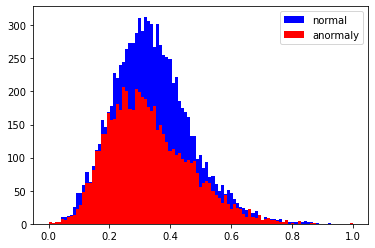

In [46]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100), color = 'b' , label = 'normal')
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100), color = 'r' , label = 'anormaly')
plt.legend()

plt.show()

## 테스트셋 이상감지 정확도(%) - 적절한 threshold에 따른 이상 감지율 계산

1. mean(normal)= 0.34055826 2. mean(anormaly)= 0.329549
3. std(normal)= 0.12717739 4. std(anormaly)= 0.13332634


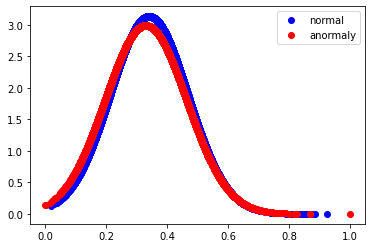

In [47]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o', color = 'b' , label='normal')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o', color = 'r' , label='anormaly')
plt.legend()

print("1. mean(normal)=", np.mean(normal), "2. mean(anormaly)=",np.mean(anormaly))
print("3. std(normal)=", np.std(normal), "4. std(anormaly)=",np.std(anormaly))

## 이상감지 성공실패사례 제시

- CIFAR-10에서 특정 클래스, 6번 라벨 개구리(Frog)를 이상 데이터로 활용함
    1. 개구리(Frog) 6번 라벨링된 모든 이미지를 훈련 데이터에서 제거하고, 나머지 클래스로만 학습을 시킴
    2. 테스트 데이터를 6번 라벨(이상 데이터를 포함한) 형태로 구성하여 이상감지 성능을 평가하는 방식임
- 위 모델은 개구리는 학습되지 않은 데이터이므로, 테스트 데이터로 개구리가 나타나면 매우 특이한 상황이라고 가정하는 것임
    1. 위 시각화 자료에서 anormaly 데이터(6번 라벨)와 normal 데이터(나머지 라벨)간의 분포가 다른 것을 확인할 수 있음 

In [228]:
def get_example(test_dataset, i):
    ex_img, ex_label = next(iter(test_dataset))
    ex_img = tf.expand_dims(ex_img[i], axis=0)
    ex_label = ex_label[i]
    return ex_img, ex_label

In [229]:
ex_img, ex_label = get_example(test_dataset, 1)
fake_img = generator(ex_img, training=True)
pred, _ = discriminator(ex_img)
label_int = np.int8(tf.reduce_sum(ex_label).numpy())
pred_int = np.int8(tf.reduce_sum(pred).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'pred : 1')

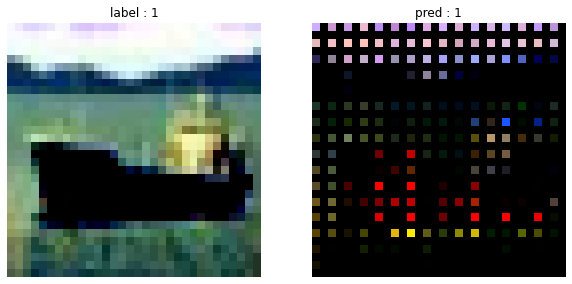

In [230]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(ex_img[0])
plt.axis('off')
plt.title(f'label : {label_int}')

plt.subplot(1,2,2)
plt.imshow(fake_img[0])
plt.axis('off')
plt.title(f'pred : {pred_int}')

In [302]:
ex_img, ex_label = get_example(test_dataset, 6)
fake_img = generator(ex_img, training=True)
pred, _ = discriminator(ex_img)
label_int = np.int8(tf.reduce_sum(ex_label).numpy())
pred_int = np.int8(tf.reduce_sum(pred).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'pred : 0')

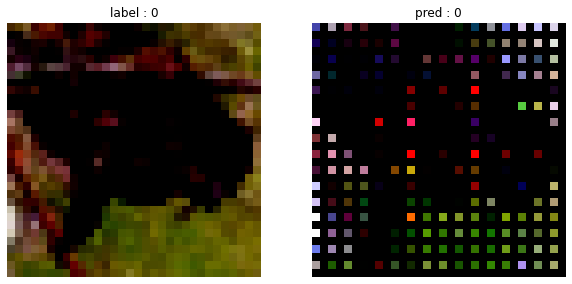

In [303]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(ex_img[0])
plt.axis('off')
plt.title(f'label : {label_int}')

plt.subplot(1,2,2)
plt.imshow(fake_img[0])
plt.axis('off')
plt.title(f'pred : {pred_int}')